# Review Data Preprocessing

## Load data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.functions import when
from pyspark.sql.functions import explode
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, ArrayType
from pyspark.sql.functions import col, length, split
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
spark = SparkSession.builder.appName("DataPreprocessing").getOrCreate()

23/11/28 23:23:10 WARN Utils: Your hostname, TruongHoang resolves to a loopback address: 127.0.1.1; using 192.168.81.115 instead (on interface wlp3s0)
23/11/28 23:23:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/28 23:23:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/28 23:23:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
schema = StructType([
    StructField("data", ArrayType(StructType([
        StructField("title", StringType(), True),
        StructField("content", StringType(), True),
        StructField("thank_count", IntegerType(), True),
        StructField("score", FloatType(), True),
        StructField("new_score", FloatType(), True),
        StructField("customer_id", IntegerType(), True),
        StructField("product_id", IntegerType(), True),
        StructField("comment_count", IntegerType(), True),
        StructField("rating", IntegerType(), True),
    ])), True)
])

In [4]:
df = spark.read.option("multiline","true").json('review.json', schema = schema)
df.printSchema()

root
 |-- data: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- title: string (nullable = true)
 |    |    |-- content: string (nullable = true)
 |    |    |-- thank_count: integer (nullable = true)
 |    |    |-- score: float (nullable = true)
 |    |    |-- new_score: float (nullable = true)
 |    |    |-- customer_id: integer (nullable = true)
 |    |    |-- product_id: integer (nullable = true)
 |    |    |-- comment_count: integer (nullable = true)
 |    |    |-- rating: integer (nullable = true)



In [5]:
df.show()

+--------------------+
|                data|
+--------------------+
|[{Rất không hài l...|
|[{Cực kì hài lòng...|
|[{Cực kì hài lòng...|
|[{Cực kì hài lòng...|
|[{rất hài lòng về...|
|[{Cực kì hài lòng...|
|[{Rất không hài l...|
|[{Cực kì hài lòng...|
|[{Cực kì hài lòng...|
|                  []|
|[{Hài lòng, Ok, 0...|
|[{Cực kì hài lòng...|
|[{Cực kì hài lòng...|
|[{Cực kì hài lòng...|
|[{Rất không hài l...|
|[{Cực kì hài lòng...|
|[{Rất không hài l...|
|[{Cực kì hài lòng...|
|[{Hài lòng, Không...|
|[{Cực kì hài lòng...|
+--------------------+
only showing top 20 rows



In [6]:
df = df.select("*", explode("data").alias("review"))
df = df.select("review.content", "review.rating", "review.product_id")

In [7]:
df.printSchema()
df.count()

root
 |-- content: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- product_id: integer (nullable = true)



215266

In [8]:
count_null_empty = df.where((col("content").isNull()) | (col("content") == "") | (col("rating").isNull())).count()
print(count_null_empty)

78150


In [9]:
df = df.where(~((col("content").isNull()) | (col("content") == "") | (col("rating").isNull())))

In [10]:
df.count()

137116

In [11]:
df = df.dropDuplicates(["content"])
df.count()

121501

In [12]:
# output_path = "/home/truonghoang/Documents/GR2/Model/data_clean.csv"
# df_selected.write.csv(output_path, header=True, mode="overwrite")

# Tiền xử lí

In [13]:
from underthesea import word_tokenize, pos_tag, sent_tokenize
import regex
import demoji
from pyvi import ViPosTagger, ViTokenizer
import string
import wordcloud

### Đọc các file trong từ điển

Đọc file để chuẩn hóa dữ liệu:
- Emoji: 👍😍😊
- Teencode
- Tiếng anh
- Từ dừng (từ nối): alô, ơi, à, ...
- Các từ phủ định: không, nhưng, ...
- Các từ sai

In [14]:
##LOAD EMOJICON
file = open('dictionary/emojicon.txt', 'r', encoding="utf8")
emoji_lst = file.read().split('\n')
emoji_dict = {}
for line in emoji_lst:
    key, value = line.split('\t')
    emoji_dict[key] = str(value)
file.close()
#################
#LOAD TEENCODE
file = open('dictionary/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()
###############
#LOAD TRANSLATE ENGLISH -> VNMESE
file = open('dictionary/english-vnmese.txt', 'r', encoding="utf8")
english_lst = file.read().split('\n')
english_dict = {}
for line in english_lst:
    key, value = line.split('\t')
    english_dict[key] = str(value)
file.close()
################
#LOAD wrong words
file = open('dictionary/wrong-word.txt', 'r', encoding="utf8")
wrong_lst = file.read().split('\n')
file.close()
#################
#LOAD STOPWORDS
file = open('dictionary/vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()
#LOAD NOTWORDS
file = open('dictionary/not.txt', 'r', encoding="utf8")
not_lst = file.read().split('\n')
file.close()

### Xứ lí comment

In [15]:
@udf(StringType())
def process_text(text):
    # Chuyển đổi về chữ thường và xóa dấu nháy đơn không phù hợp
    document = text.lower().replace("’", '')

    # Thay thế dấu chấm đoạn thành một dấu chấm
    document = re.sub(r'\.(\.+)', '.', document)

    new_sentence = ''

    # Vòng lặp qua từng câu
    for sentence in sent_tokenize(document):
        # Chuyển đổi emoji
        sentence = ''.join(' ' + emoji_dict[word] + ' ' if word in emoji_dict else word for word in list(sentence))

        # Loại bỏ dấu câu, số và chỉ giữ lại từ
        pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
        sentence = ' '.join(regex.findall(pattern, sentence))

        # Chuyển đổi teen code
        sentence = ' '.join(teen_dict[word] if word in teen_dict else word for word in sentence.split())

        # Loại bỏ các từ không mong muốn
        sentence = ' '.join('' if word in wrong_lst else word for word in sentence.split())
        
        # Ghi vào new_sentence
        new_sentence = new_sentence + sentence + '. '

    # Xóa khoảng trắng dư thừa và loại bỏ các lặp lại của ký tự
    document = re.sub(r'\s+', ' ', new_sentence).strip()
    document = re.sub(r'([a-z])\1+', lambda m: m.group(1).lower(), document, flags=re.IGNORECASE)

    return document

## Chuẩn hóa unicode tiếng việt

In [16]:
def loaddicchar():
    uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
    unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

@udf(StringType())
def convert_unicode(txt):
    dicchar = loaddicchar()
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [17]:
def process_special_word(text):
    new_text = []
    text_lst = text.split()

    i = 0
    while i < len(text_lst):
        word = text_lst[i]
        if word in not_lst:
            next_idx = i + 1
            if next_idx < len(text_lst):
                word = f"{word}_{text_lst[next_idx]}"
                i = next_idx + 1
            else:
                break
        else:
            i = i + 1
        new_text.append(word)

    return ' '.join(new_text).strip()

### Phân loại từ vựng 

In [18]:
@udf(StringType())
def process_postag_thesea(text):
    new_document = ''

    for sentence in sent_tokenize(text):
        sentence = sentence.replace('.', '')
        
        # POS tag
        lst_word_type = {'A', 'AB', 'V', 'VB', 'VY', 'R', 'M'}
        processed_sentence = pos_tag(process_special_word(word_tokenize(sentence, format="text")))
        
        # Filter words based on POS tags
        sentence = ' '.join(word[0] if word[1].upper() in lst_word_type else '' for word in processed_sentence)
        new_document += sentence + ' '

    # Remove excess blank spaces
    new_document = re.sub(r'\s+', ' ', new_document).strip()

    return new_document

### Loại bỏ từ dừng

In [19]:
@udf(StringType())
def remove_stopword(text):
    # REMOVE stop words
    document = ' '.join('' if word in stopwords_lst else word for word in text.split())
    
    # DEL excess blank space
    document = re.sub(r'\s+', ' ', document).strip()
    
    return document

In [20]:
df = df.withColumn("text", process_text(df["content"]))
df = df.withColumn("text", convert_unicode(df["text"]))
df = df.withColumn("text", process_postag_thesea(df["text"]))
df = df.withColumn("text", remove_stopword(df["text"]))

In [21]:
df.printSchema()

root
 |-- content: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- text: string (nullable = true)



In [22]:
df.select("text").show()

+--------------------+
|                text|
+--------------------+
|khuyến_mãi được t...|
|tốt tin_tưởng tiế...|
|dão không_chắc_ch...|
|tốt đầu_đàn giảm ...|
|được bọc kỹ tem n...|
|                 sai|
|               nhanh|
|               nhanh|
|đẹp vừa vặn đẹp t...|
|đẹp_giáo nhanh th...|
|đủ chất mỏng khôn...|
|                  ok|
|hổ_trợ nhiệt_tình...|
|được đúng được bề...|
|              ổn sứt|
|ổn dày đẹp khá hà...|
|hoạt_động tốt bấm...|
|           nhanh đẹp|
|                loai|
|              ổn lâu|
+--------------------+
only showing top 20 rows



In [23]:
conditions = [
    (df['rating'] == 1, 'negative'),
    (df['rating'] == 5, 'positive')
]

default_label = 'neutral'
df = df.withColumn('label', 
                           when(conditions[0][0], conditions[0][1])
                           .when(conditions[1][0], conditions[1][1])
                           .otherwise(default_label))

# Show the resulting DataFrame
df.show()

+--------------------+------+----------+--------------------+--------+
|             content|rating|product_id|                text|   label|
+--------------------+------+----------+--------------------+--------+
|M mua theo chương...|     1|  95269391|khuyến_mãi được t...|negative|
|Mua sữa của Tiki ...|     1|  45551664|tốt tin_tưởng tiế...|negative|
|Sản phẩm không nh...|     1|  48952800|dão không_chắc_ch...|negative|
|Xài rất tốt. Lần ...|     5|  76099465|tốt đầu_đàn giảm ...|positive|
|Sản phẩm được bọc...|     4| 161211248|được bọc kỹ tem n...| neutral|
|Giao sai hàng, đặ...|     5|   9724337|                 sai|positive|
|Khung chắc chắn...|     5| 154702528|               nhanh|positive|
|    Giao hàng nhanh!|     5|    417954|               nhanh|positive|
|Hàng đẹp trước mì...|     4| 101247107|đẹp vừa vặn đẹp t...| neutral|
|Cờ đẹp, giáo hàng...|     5|  22376486|đẹp_giáo nhanh th...|positive|
|Giao đủ số lượng,...|     4|  89221426|đủ chất mỏng khôn...| neutral|
|Sản p

# Visualize Data

In [24]:
import pandas as pd
df.count()

121501

In [25]:
df_content_to_pd = df.select("content").toPandas()
df_rating_to_pd = df.select("rating").toPandas()
df_label_to_pd = df.select("label").toPandas()

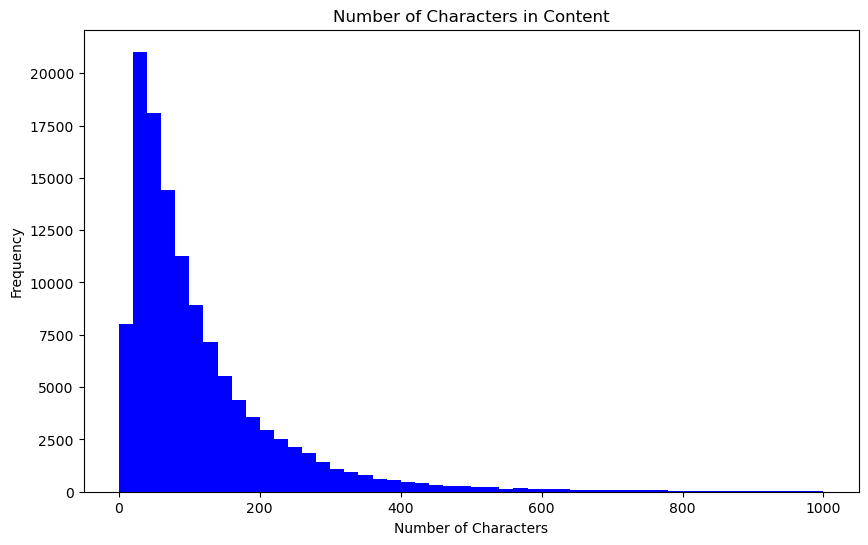

In [26]:
plt.figure(figsize=(10, 6))
plt.hist(df_content_to_pd['content'].str.len(), bins=50, range=(0, 1000), color='blue')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.title('Number of Characters in Content')
plt.show()

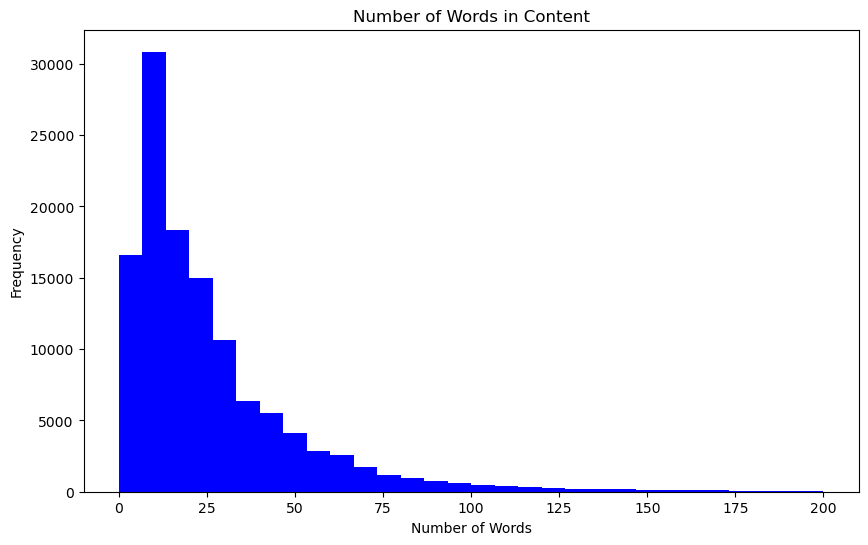

In [27]:
plt.figure(figsize=(10, 6))
plt.hist(df_content_to_pd['content'].apply(lambda x: len(x.split()) if x is not None else 0), bins=30, range=(0, 200), color='blue')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Number of Words in Content')
plt.show()

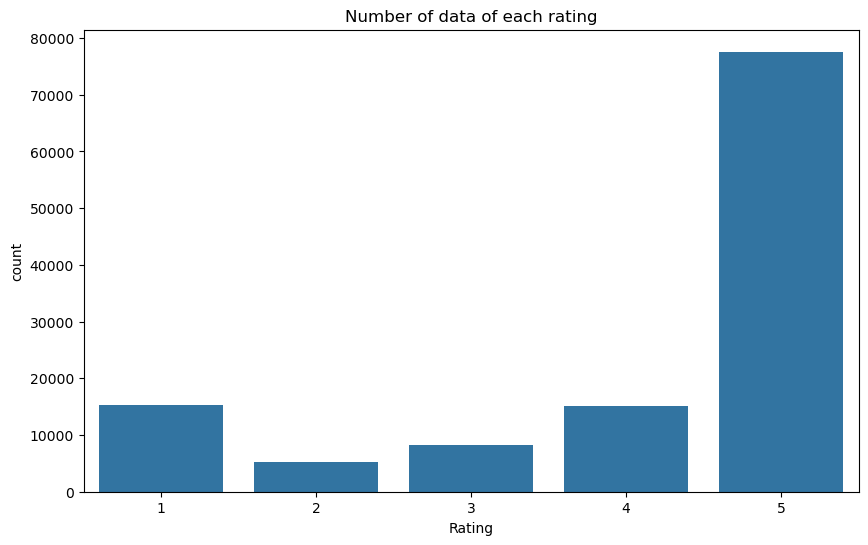

In [28]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=df_rating_to_pd)
plt.xlabel("Rating")
plt.title("Number of data of each rating")
plt.show()

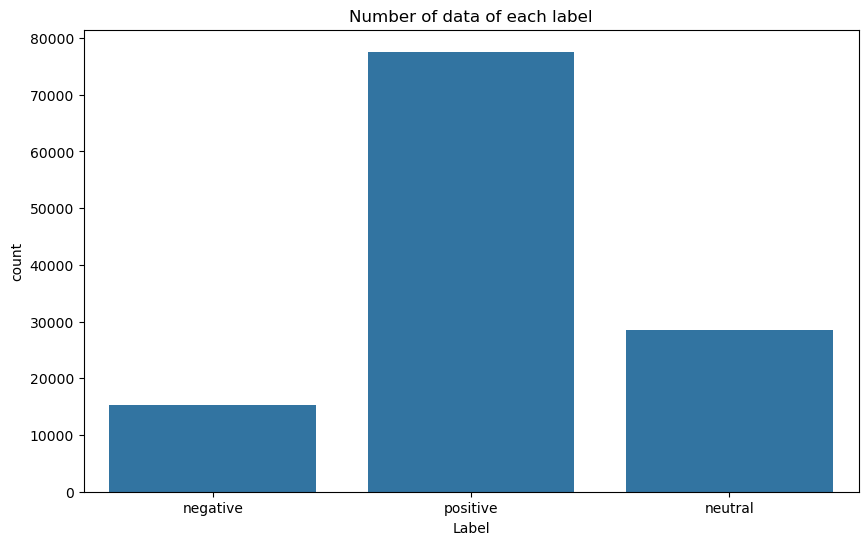

In [29]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df_label_to_pd)
plt.xlabel("Label")
plt.title("Number of data of each label")
plt.show()

In [ ]:
df = df.select("text","label", "product_id");
df = df.na.drop()
output_path = "/home/truonghoang/Documents/GR2/Model/review_data_clean.csv"
df.write.csv(output_path, header=True, mode="overwrite")